# Preprocess/Train/Test/Val

## Train

In [6]:
import sys
curr_dir ='/home/users/maali/Computer_vision_SOC'
source ='/home/users/maali/Computer_vision_SOC/source'
sys.path.append(curr_dir)
sys.path.append(source)

import sys
import pandas as pd 
import numpy as np
import os
from Preprocessor import Preprocessor
from Sampler import Sampler 
from ObjectDetection import ObjectDetector 
from imageProcessor import ImageProcessor 
from ultralytics import YOLO


########################################Data Preparation######################################################

train_image_folder = curr_dir+'/data/images/train/'
val_image_folder = curr_dir+'/data/images/val/'
test_image_folder = curr_dir+'/data/images/test/'
train_data_csv = curr_dir+'/backup/labels/train.csv'
test_data_csv = curr_dir+'/backup/labels/val.csv'

processor = Preprocessor(train_image_folder,val_image_folder,train_data_csv,test_data_csv)
all_labels = processor.all_labels

train_data_pd,test_data_pd = processor.train_df,processor.val_df
new_train_data_pd,val_data_pd = processor.make_train_val_dfs(train_data_pd)

#move val images to val directory 
processor.move_files_to_val_directory(val_data_pd,source_directory= curr_dir+"/data/images/train",destination_directory =curr_dir+"/data/images/val")

#make labels directories in yolo format
processor.Yolo_labels_maker(new_train_data_pd,curr_dir+'/data/labels/train',skip=True)
processor.Yolo_labels_maker(val_data_pd,curr_dir+'/data/labels/val',skip=True)
processor.Yolo_labels_maker(test_data_pd,curr_dir+'/data/labels/test',skip=True)


########################################Sampling############################################################
sampler = Sampler(new_train_data_pd, val_data_pd, test_data_pd,train=1,val=200,test=200)
sampler.make_samples(skip=True)

########################################Augmentation########################################################
img_processor = ImageProcessor(sampler.sampled_train_df,sampler.sampled_val_df,sampler.sampled_test_df,)

bg_aug_train_df = img_processor.new_backgrounds_augment(sampler.sampled_train_df,skip=True)
processor.Yolo_labels_maker(bg_aug_train_df,curr_dir+'/samples/train/labels',skip=True,yolo_format=True,keep=True)


crop_aug_train_df = img_processor.crop_flip_augment(sampler.sampled_train_df,skip = True)
processor.Yolo_labels_maker(crop_aug_train_df,curr_dir+'/samples/train/labels',skip=True,yolo_format=True,keep=True)

########################################Training############################################################

detector = ObjectDetector(data = curr_dir+'/config.yaml',model = '/home/users/maali/Computer_vision_SOC/runs/detect/train16/weights/best.pt')

#detector.train_yolo_model(epochs=150,patience =10,imgsz = 256, batch = 16,lr0=0.001 ,optimizer = 'SGD')                        

validation images already exist, skipping...


### utility functions

In [23]:
def run_testing(test_images, model,dataset ='test',imgsiz=256):
    test_images = test_images

    predictions_df = detector.predict_with_yolo(test_images,all_labels,model =model, imgsiz=imgsiz)
    if dataset =='train':
        true_df = test_data_pd[['filename','class','bbox']]
    elif  dataset =='test':
         true_df = test_data_pd[['filename','class','bbox']]
    else:
        true_df = val_data_pd[['filename','class','bbox']]

    overall_dict,class_wise_stats,merged_df = detector.classification_report(true_df,predictions_df,all_labels)
    iou_scores = detector.iou_report(true_df, predictions_df,all_labels)
    return  true_df,overall_dict,class_wise_stats,merged_df,iou_scores,predictions_df

def run_validation(model_path,data_path):
    model = YOLO(model_path)  
    # Validate the model
    metrics = model.val(data = data_path)  
    metrics.box.map50  # map50
    metrics.box.maps 

## Test/Validation

IOU and CLASSIFICTION results, saved in /PerformanceResults 

In [33]:
model_path = '/home/users/maali/detect/train15/weights/best.pt'

true_df,overall_dict,class_wise_stats,merged_df,iou_scores,predictions_df= run_testing(curr_dir+'/samples/test/images', model =model_path,dataset='test',imgsiz=512) 



image 1/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000105.jpg: 512x512 1 proba_2, 14.6ms
image 2/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000116.jpg: 512x512 1 proba_2, 14.6ms
image 3/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000124.jpg: 512x512 1 proba_2, 14.6ms
image 4/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000145.jpg: 512x512 1 proba_2, 14.6ms
image 5/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000167.jpg: 512x512 1 proba_2, 14.6ms
image 6/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000235.jpg: 512x512 1 proba_2, 14.6ms
image 7/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000280.jpg: 512x512 1 proba_2, 14.6ms
image 8/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000303.jpg: 512x512 1 proba_2, 14.6ms
image 9/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000336.jpg: 512x512 1 proba_2

## Predictions boxes visualization

In [10]:

detector.test_predict(model=curr_dir+'/runs/detect/train2/weights/best.pt',project = "/home/users/maali/Computer_vision_SOC/source")


image 1/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img000645.jpg: 256x256 1 proba_2, 9.1ms
image 2/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img007367.jpg: 256x256 1 proba_2, 9.2ms
image 3/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img008500.jpg: 256x256 1 proba_2, 9.1ms
image 4/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img021220.jpg: 256x256 1 debris, 9.2ms
image 5/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img038839.jpg: 256x256 1 double_star, 9.2ms
image 6/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img046137.jpg: 256x256 1 earth_observation_sat_1, 9.1ms
image 7/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img062319.jpg: 256x256 1 proba_3_ocs, 9.0ms
image 8/10 /home/users/maali/Computer_vision_SOC/samples/test_predict_samples/img091849.jpg: 256x256 1 proba_3_csc, 9.1ms
image 9/10 /home/users/maali

Displaying images for class: cheops


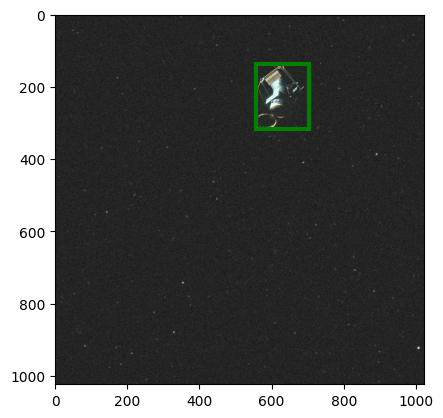

Displaying images for class: debris


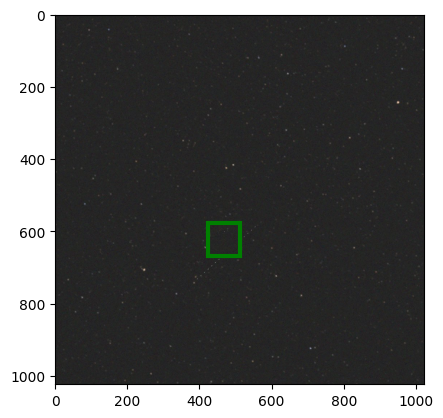

Displaying images for class: double_star


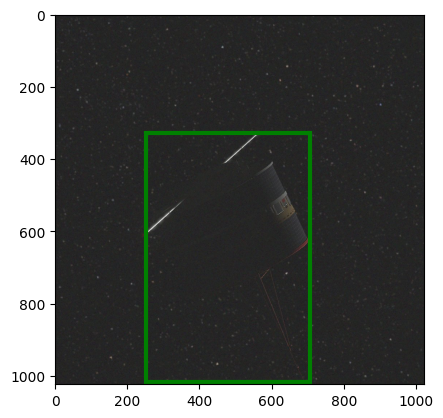

Displaying images for class: earth_observation_sat_1


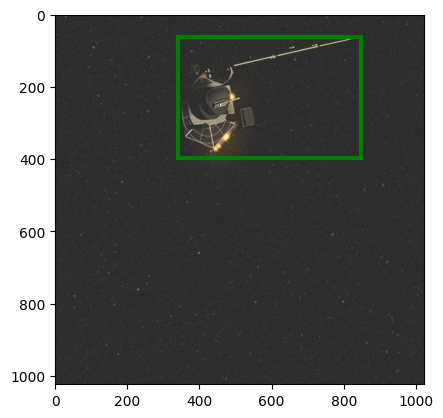

Displaying images for class: lisa_pathfinder


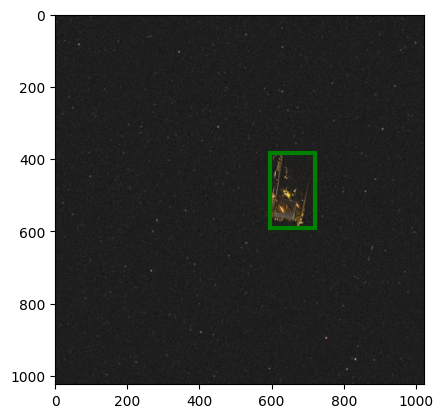

Displaying images for class: proba_2


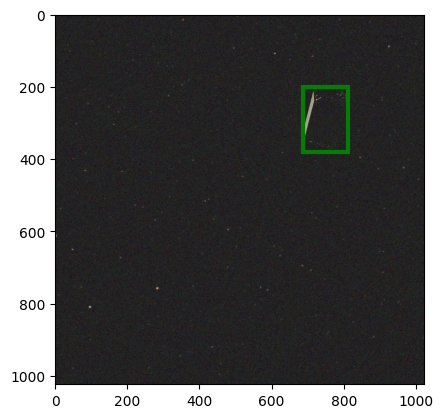

Displaying images for class: proba_3_csc


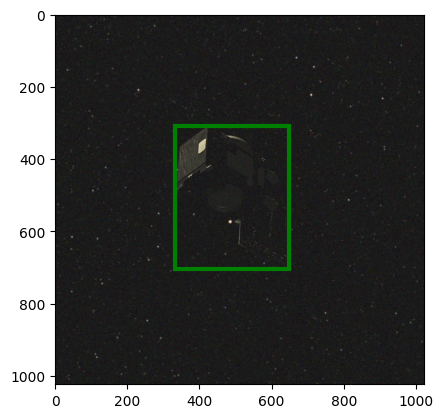

Displaying images for class: proba_3_ocs


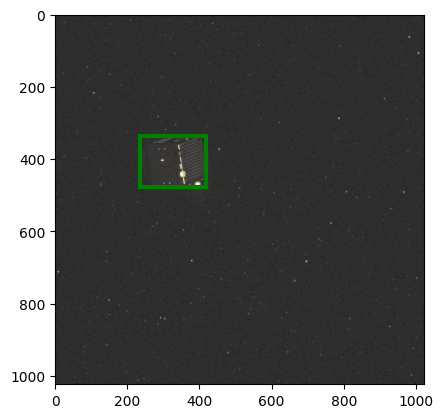

Displaying images for class: smart_1


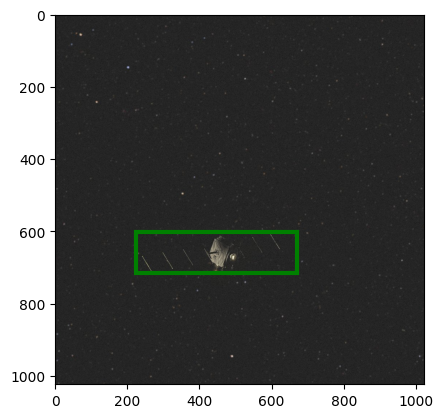

Displaying images for class: soho


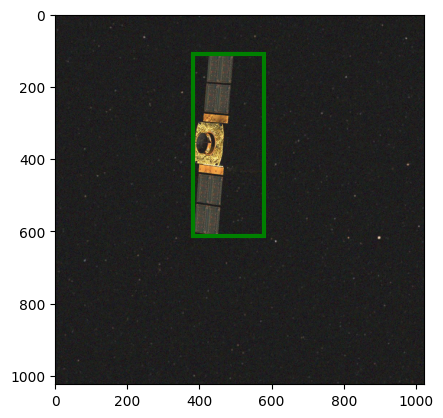

Displaying images for class: xmm_newton


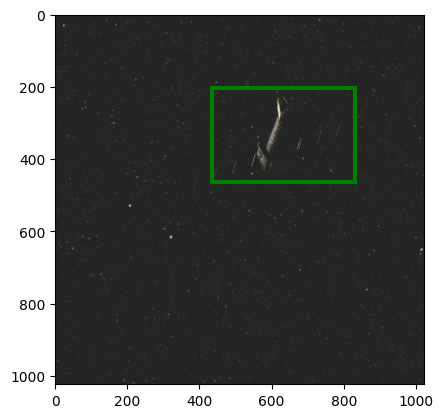

In [11]:
processor.show_image_per_class(predictions_df,curr_dir+'/samples/test/images',sample=1)

## Validation 

In [19]:

run_validation(curr_dir+'/runs/detect/train13/weights/best.pt','/home/users/maali/Computer_vision_SOC/config.yaml')

Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 68134161 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /mnt/irisgpfs/users/maali/Computer_vision_SOC/data/labels/val.cache... 13200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13200/13200 [00:00<?, ?it/s]
/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 825/825 [02:15<00:00,  6.10it/s]  


                   all      13200      13200       0.95      0.894      0.939      0.784
               smart_1      13200       1199      0.839      0.796      0.827      0.704
                cheops      13200       1188      0.946       0.96      0.983      0.855
       lisa_pathfinder      13200       1230      0.987      0.985      0.995      0.906
                debris      13200       1145      0.983      0.968       0.99      0.779
                  soho      13200       1188      0.917      0.861      0.925      0.735
           proba_3_ocs      13200       1195      0.962      0.952      0.986      0.802
           proba_3_csc      13200       1174      0.978      0.951      0.986       0.87
earth_observation_sat_1      13200       1192      0.958      0.739      0.844      0.625
               proba_2      13200       1228       0.97      0.953      0.975      0.865
            xmm_newton      13200       1249      0.947      0.743      0.849      0.659
           double_st

# Limitations Analysis


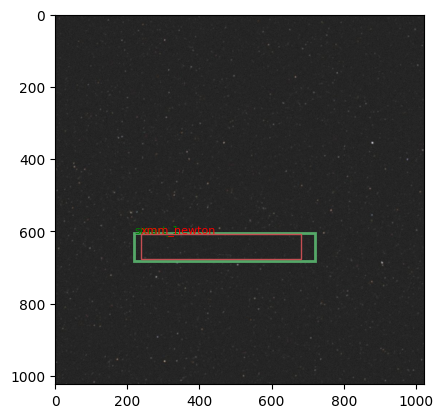

In [27]:
false_positives_df = detector.collect_false_positives(true_df, predictions_df,iou_scores)

detector.show_false_positives(false_positives_df,curr_dir+'/samples/test/images',sample_size=1, classname='smart_1')

Statistics regarding the false positives, no detections and miss_classifications

In [28]:
all_classes_stats = detector.miss_stats(true_df, predictions_df,false_positives_df,all_labels)
all_classes_stats

nbr_Images False_positives No_detections  \
smart_1                         200       2 (1.00%)     2 (1.00%)   
cheops                          200       2 (1.00%)     1 (0.50%)   
proba_3_ocs                     200       3 (1.50%)     1 (0.50%)   
proba_2                         200       2 (1.00%)     0 (0.00%)   
earth_observation_sat_1         200       7 (3.50%)     9 (4.50%)   
xmm_newton                      200       6 (3.00%)     8 (4.00%)   
double_star                     200       2 (1.00%)     0 (0.00%)   
lisa_pathfinder                 200       0 (0.00%)     0 (0.00%)   
debris                          200       0 (0.00%)     1 (0.50%)   
proba_3_csc                     200       0 (0.00%)     1 (0.50%)   
soho                            200       4 (2.00%)     1 (0.50%)   
All                            2200      28 (1.27%)    24 (1.09%)   

                        Miss_classification  
smart_1                           2 (1.00%)  
cheops                            2 (1.00%)  
proba_3_ocs                       2 (1.00%)  
proba_2                           2 (1.00%)  
earth_observation_sat_1           1 (0.50%)  
xmm_newton                        1 (0.50%)  
double_star                       1 (0.50%)  
lisa_pathfinder                   0 (0.00%)  
debris                            0 (0.00%)  
proba_3_csc                       0 (0.00%)  
soho                              0 (0.00%)  
All                              11 (0.50%)

# Experimentation with the The false,positives and no detections

## Part1
we isolated the images were the model is faltering, apply new background augementation, freeze the backbone, reduce the learning rate,batch size and increase the image resolution and retrain the model.

In [ ]:
detector = ObjectDetector(data = curr_dir+'/config2.yaml',model = curr_dir+'/runs/detect/train2/weights/best.pt')
detector.train_yolo_model(epochs=150,patience =15,imgsz=512, batch = 8,lr0=0.0001 ,optimizer = 'SGD', cos_lr=True,freeze=10)                        

In [7]:
model_path = '/home/users/maali/detect/train7/weights/best.pt'
true_df,overall_dict,class_wise_stats,merged_df,iou_scores,predictions_df= run_testing(curr_dir+'/samples/test/images', model =model_path,dataset='test',imgsiz=512) 
# run_validation(model_path,'/home/users/maali/Computer_vision_SOC/config2.yaml')


image 1/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000105.jpg: 512x512 1 proba_2, 14.2ms
image 2/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000116.jpg: 512x512 1 proba_2, 14.3ms
image 3/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000124.jpg: 512x512 1 proba_2, 14.3ms
image 4/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000145.jpg: 512x512 1 proba_2, 14.3ms
image 5/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000167.jpg: 512x512 1 proba_2, 14.3ms
image 6/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000235.jpg: 512x512 1 proba_2, 14.2ms
image 7/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000280.jpg: 512x512 1 proba_2, 12.5ms
image 8/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000303.jpg: 512x512 1 proba_2, 12.5ms
image 9/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000336.jpg: 512x512 1 proba_2

## Part 2

In [113]:
import shutil
def copy_files_to_directory(valdf, source_directory, destination_directory):
        # Create the output directory if it doesn't exist
        os.makedirs(destination_directory, exist_ok=True)
       
        if os.path.exists(destination_directory) and os.listdir(destination_directory):
            print('validation images already exist, skipping...')
            return 

        # Iterate through the DataFrame and move files to the 'val' directory
        for index, row in valdf.iterrows():
            source_path = os.path.join(source_directory, row['filename'])
            destination_path = os.path.join(destination_directory, row['filename'])
            
            if os.path.exists(source_path):
                shutil.copy(source_path, destination_path)
            else:
                print('Image file does not exist')
                
def make_misses_dataset(true_df,predictions_df,source_directory,destination_directory,label_destination_dir):
    false_positives_df = detector.collect_false_positives(true_df, predictions_df,iou_scores)[['filename','class_x','bbox_x']].rename(columns={'class_x':'class','bbox_x':'bbox'})
    no_detections_df = predictions_df[(predictions_df['class'] == 'no detection') & (~predictions_df['filename'].str.contains('background'))]
    missed_images_df = pd.concat([false_positives_df,no_detections_df])
    processor.make_numeric_class(missed_images_df)
    copy_files_to_directory(missed_images_df,source_directory= source_directory,destination_directory =destination_directory)
    processor.Yolo_labels_maker(missed_images_df,label_destination_dir,skip=False)
    return missed_images_df


#run inference on missed images with best model so far
missed_images_dir='/home/users/maali/Computer_vision_SOC/data/images/misses/train/images'
true_df,overall_dict,class_wise_stats,merged_df,iou_scores,predictions_df= run_testing(missed_images_dir, model =model_path,dataset='train',imgsiz=512,project='detect') 

#collect new set of missef images to retain on 
missed_images_df = make_misses_dataset(true_df,predictions_df,curr_dir+"/data/images/misses/test",curr_dir+"/data/images/misses2/train/images",curr_dir+"/data/images/misses2/train/labels")
bg_aug_train_df = img_processor.new_backgrounds_augment(missed_images_df,image_dir=curr_dir+"/data/images/misses2/train/images",output_dir=curr_dir+"/data/images/misses2/train/images",skip=False)
processor.Yolo_labels_maker(bg_aug_train_df,curr_dir+"/data/images/misses2/train/labels",skip=False,yolo_format=True,keep=True)

yolo-format labels  made..


filename            class                  bbox  num_labels
50     img056285.jpg  lisa_pathfinder   [376, 87, 595, 255]           2
77     img050322.jpg  lisa_pathfinder      [0, 0, 374, 347]           2
87     img057152.jpg  lisa_pathfinder  [186, 432, 340, 544]           2
102    img057289.jpg  lisa_pathfinder     [0, 854, 32, 951]           2
177    img058016.jpg  lisa_pathfinder  [258, 722, 336, 848]           2
...              ...              ...                   ...         ...
21824  img037751.jpg      double_star  [619, 417, 712, 571]          10
21860  img036167.jpg      double_star  [602, 350, 706, 420]          10
21902  img034302.jpg      double_star  [164, 397, 527, 594]          10
21945  img036787.jpg      double_star  [413, 388, 517, 535]          10
21972  img035470.jpg      double_star  [441, 362, 596, 632]          10

[654 rows x 4 columns]

In [21]:
#retrain model
model_path = '/home/users/maali/detect/train15/weights/best.pt'
detector = ObjectDetector(data = curr_dir+'/config2.yaml',model = model_path)
detector.train_yolo_model(epochs=150,patience =15,imgsz=640, batch=8,lr0=0.0001,optimizer = 'SGD',cos_lr=True,freeze=0,project='detect')                    

Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=/home/users/maali/detect/train15/weights/best.pt, data=/home/users/maali/Computer_vision_SOC/config2.yaml, epochs=150, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=detect, name=train13, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=1, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640

train: Scanning /mnt/irisgpfs/users/maali/Computer_vision_SOC/data/images/misses2/train/labels.cache... 1308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1308/1308 [00:00<?, ?it/s]
/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
val: Scanning /mnt/irisgpfs/users/maali/Computer_vision_SOC/data/images/misses/val/labels.cache... 1074 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1074/1074 [00:00<?, ?it/s]
/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader wil

Plotting labels to detect/train13/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      16.9G     0.5455     0.7082      1.017         19        640: 100%|██████████| 82/82 [00:33<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]

                   all       1074       1074      0.777      0.746      0.798      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      13.4G     0.5345     0.6473       1.01         19        640: 100%|██████████| 82/82 [00:33<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]

                   all       1074       1074      0.793      0.697      0.761      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      13.4G     0.5221     0.6376     0.9996         14        640: 100%|██████████| 82/82 [00:32<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]

                   all       1074       1074      0.585       0.57      0.538      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      13.8G     0.5655     0.6875       1.03         14        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

                   all       1074       1074      0.505      0.446      0.455      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      13.7G     0.5954     0.6805      1.044         15        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]

                   all       1074       1074      0.606      0.569      0.594      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      13.7G      0.574     0.6844      1.033         17        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

                   all       1074       1074      0.692      0.625       0.66      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      13.7G     0.5789      0.665       1.03         18        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]

                   all       1074       1074       0.64      0.583      0.598       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      13.7G     0.5499     0.6252       1.02         16        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.86it/s]

                   all       1074       1074      0.582      0.578      0.556      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      13.7G     0.5519      0.604      1.014         12        640: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

                   all       1074       1074      0.722       0.72      0.706      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      13.7G     0.5636     0.5826      1.013         19        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

                   all       1074       1074      0.674      0.598      0.625      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      13.7G     0.5564     0.6198      1.009         11        640: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]

                   all       1074       1074      0.637      0.591      0.597      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      13.7G     0.5523     0.5879      1.016         19        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]

                   all       1074       1074       0.48      0.456      0.437      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      13.7G     0.5591     0.5955      1.017         27        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]

                   all       1074       1074       0.42      0.402      0.342      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      13.7G     0.5299     0.5865      1.003         16        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

                   all       1074       1074      0.554      0.577      0.529      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      13.7G     0.5615     0.5842       1.02         19        640: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.83it/s]

                   all       1074       1074       0.55      0.535        0.5      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      13.7G     0.5414     0.5717      1.005         14        640: 100%|██████████| 82/82 [00:32<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]

                   all       1074       1074      0.675      0.677      0.665      0.403
Stopping training early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.204 hours.
Optimizer stripped from detect/train13/weights/last.pt, 136.7MB
Optimizer stripped from detect/train13/weights/best.pt, 136.7MB

Validating detect/train13/weights/best.pt...
Ultralytics YOLOv8.0.232 🚀 Python-3.8.6 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
Model summary (fused): 268 layers, 68134161 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:12<00:00,  2.75it/s]


                   all       1074       1074      0.777      0.746      0.798      0.528
               smart_1       1074        223      0.936       0.74      0.852      0.472
                cheops       1074         31       0.81      0.645      0.755      0.453
       lisa_pathfinder       1074          7      0.381      0.857      0.726      0.548
                debris       1074         15      0.726        0.8      0.851      0.594
           proba_3_ocs       1074        158      0.824      0.854      0.891      0.699
           proba_3_csc       1074         22      0.795      0.909      0.866      0.494
                  soho       1074         42      0.741      0.681      0.714      0.405
earth_observation_sat_1       1074        243      0.649      0.687      0.685      0.437
               proba_2       1074         68      0.856      0.721      0.834      0.574
            xmm_newton       1074        217      0.897      0.561      0.751      0.492
           double_st

In [17]:

# test model
model_path = '/home/users/maali/detect/train15/weights/best.pt'
true_df,overall_dict,class_wise_stats,merged_df,iou_scores,predictions_df= run_testing(curr_dir+'/samples/test/images', model =model_path,dataset='test',imgsiz=640) 
run_validation(model_path,'/home/users/maali/Computer_vision_SOC/config3.yaml')


WARNING ⚠️ imgsz=[612] must be multiple of max stride 32, updating to [640]
image 1/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000105.jpg: 640x640 1 proba_2, 22.1ms
image 2/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000116.jpg: 640x640 1 proba_2, 22.1ms
image 3/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000124.jpg: 640x640 1 proba_2, 22.2ms
image 4/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000145.jpg: 640x640 1 proba_2, 19.7ms
image 5/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000167.jpg: 640x640 1 proba_2, 19.6ms
image 6/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000235.jpg: 640x640 1 proba_2, 19.5ms
image 7/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000280.jpg: 640x640 1 proba_2, 19.5ms
image 8/2200 /home/users/maali/Computer_vision_SOC/samples/test/images/img000303.jpg: 640x640 1 proba_2, 19.6ms
image 9/2200 /home/users/ma

val: Scanning /mnt/irisgpfs/users/maali/Computer_vision_SOC/samples/test/labels.cache... 2200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2200/2200 [00:00<?, ?it/s]
/mnt/irisgpfs/users/maali/ultra_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 138/138 [01:41<00:00,  1.36it/s]


                   all       2200       2200       0.94       0.86      0.925       0.74
               smart_1       2200        200      0.794       0.71      0.738      0.535
                cheops       2200        200      0.952      0.801      0.923      0.653
       lisa_pathfinder       2200        200      0.969      0.975      0.992      0.894
                debris       2200        200       0.99      0.993      0.995      0.893
           proba_3_ocs       2200        200      0.928      0.898      0.953       0.79
           proba_3_csc       2200        200      0.903      0.885      0.946      0.735
                  soho       2200        200      0.967      0.875      0.956      0.734
earth_observation_sat_1       2200        200      0.972      0.873      0.944       0.76
               proba_2       2200        200      0.906      0.875      0.918      0.702
            xmm_newton       2200        200      0.967      0.741      0.907      0.683
           double_st

# submission


In [18]:
predictions_df_submission = detector.predict_with_yolo(curr_dir+"/data/test",all_labels,model=model_path, imgsiz=640)

Traceback (most recent call last):
  File "/opt/apps/resif/iris-rhel8/2020b/gpu/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/opt/apps/resif/iris-rhel8/2020b/gpu/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/apps/resif/iris-rhel8/2020b/gpu/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



image 1/22000 /home/users/maali/Computer_vision_SOC/data/test/img000006.jpg: 640x640 1 proba_2, 22.2ms
image 2/22000 /home/users/maali/Computer_vision_SOC/data/test/img000012.jpg: 640x640 1 proba_2, 22.2ms
image 3/22000 /home/users/maali/Computer_vision_SOC/data/test/img000026.jpg: 640x640 1 proba_2, 22.2ms
image 4/22000 /home/users/maali/Computer_vision_SOC/data/test/img000032.jpg: 640x640 1 proba_2, 21.8ms
image 5/22000 /home/users/maali/Computer_vision_SOC/data/test/img000035.jpg: 640x640 1 proba_2, 21.7ms
image 6/22000 /home/users/maali/Computer_vision_SOC/data/test/img000037.jpg: 640x640 1 proba_2, 21.7ms
image 7/22000 /home/users/maali/Computer_vision_SOC/data/test/img000039.jpg: 640x640 1 proba_2, 21.7ms
image 8/22000 /home/users/maali/Computer_vision_SOC/data/test/img000046.jpg: 640x640 1 proba_2, 21.7ms
image 9/22000 /home/users/maali/Computer_vision_SOC/data/test/img000051.jpg: 640x640 1 proba_2, 21.7ms
image 10/22000 /home/users/maali/Computer_vision_SOC/data/test/img000053

In [19]:
nd= predictions_df_submission[predictions_df_submission['class'] == 'no detection']
nd

filename         class          bbox
128    img000586.jpg  no detection  no detection
739    img003731.jpg  no detection  no detection
1087   img005421.jpg  no detection  no detection
1560   img007796.jpg  no detection  no detection
1754   img008775.jpg  no detection  no detection
...              ...           ...           ...
21919  img109554.jpg  no detection  no detection
21940  img109622.jpg  no detection  no detection
21972  img109795.jpg  no detection  no detection
21975  img109835.jpg  no detection  no detection
21987  img109905.jpg  no detection  no detection

[284 rows x 3 columns]

In [20]:
import pandas as pd
import numpy as np

def make_submisson(df, file_path, index=False):
    try:
        df['filename'] = df['filename'].str.replace('.jpg', '.png', regex=False)
        df['bbox'] = df['bbox'].replace('no detection', np.nan, regex=False)
        df['class'] = df['class'].replace('no detection', np.nan, regex=False)
        df = df.ffill()
        df.to_csv(file_path, index=index)
        print(f"DataFrame is saved successfully to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the DataFrame to CSV: {e}")

predictions = predictions_df.copy(deep=True)
# predictions_df = pd.read_csv('/home/users/maali/Computer_vision_SOC/performanceResults/submission2.csv')
make_submisson(predictions, curr_dir+'/source/submission/submission.csv')


DataFrame is saved successfully to /home/users/maali/Computer_vision_SOC/source/submission/submission.csv
